<a href="https://colab.research.google.com/github/sdlm/pytorch_mnist/blob/master/card_mask_unet_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import skimage.io as io
from tqdm import tqdm_notebook, tqdm

from skimage.draw import ellipse, polygon

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.losses import binary_crossentropy
import tensorflow as tf
import keras as keras

from keras import backend as K

from tqdm import tqdm_notebook
h_size = 512
w_size = 512
train_num = 100
train_x = np.zeros((train_num, h_size, w_size, 3), dtype='float32')
train_y = np.zeros((train_num, h_size, w_size, 1), dtype='float32')

img_l = np.random.sample((h_size, w_size, 3)) * 0.5
img_h = np.random.sample((h_size, w_size, 3)) * 0.5 + 0.5

radius_min = 10
radius_max = 30

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def get_iou_vector(A, B):
    # Numpy version
    A = A.numpy()
    B = B.numpy()
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_function(get_iou_vector, [label, pred > 0.5], tf.float64)



from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'bce_dice_loss': bce_dice_loss })
get_custom_objects().update({'dice_loss': dice_loss })
get_custom_objects().update({'dice_coef': dice_coef })
get_custom_objects().update({'my_iou_metric': my_iou_metric })


In [0]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer


In [0]:
def next_pair():
    p = np.random.sample() - 0.5 # пока не успользуем
    r = np.random.sample()*(w_size-2*radius_max) + radius_max # r,c - координаты центра эллипса
    c = np.random.sample()*(w_size-2*radius_max) + radius_max #
    r_radius = np.random.sample()*(radius_max-radius_min) + radius_min # большой и малый радиусы эллипса
    c_radius = np.random.sample()*(radius_max-radius_min) + radius_min #
    rot = np.random.sample()*360 #  наклон эллипса
    rr, cc = ellipse(r, c, r_radius, c_radius, rotation=np.deg2rad(rot), shape=img_l.shape) # получаем все точки эллипса

    img = img_h.copy() # красим пиксели моря/фона в шум от 0.5 до 1.0
    img[rr, cc] = img_l[rr, cc] # красим пиксели эллипса в шум от 0.0  до 0.5
    
    msk = np.zeros((w_size, w_size, 1), dtype='float32')
    msk[rr, cc] = 1. # красим пиксели маски эллипса

    return img, msk


In [0]:
import re
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
ia.seed(1)

batch_size = 10
visible_batch_size = 4

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
sample_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_512.jpg', pilmode="RGB")
mask_img = imageio.imread('/content/gdrive/My Drive/colab/original_sample_mask_512.jpg', pilmode="RGB", as_gray=True)

original_smpl = np.array(sample_img, dtype=np.uint8)
original_mask = np.array(mask_img, dtype=np.uint8)
original_mask = original_mask.reshape(h_size, w_size, 1)

In [0]:
seq = iaa.SomeOf(1, [
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        rotate=(-10, 10),
        shear=(-20, 20),
        mode='wrap'
    )
])

In [0]:
def next_pair():
    _aug = seq._to_deterministic()
    return _aug.augment_image(original_smpl), _aug.augment_image(original_mask)

In [0]:
for k in range(train_num): # генерация всех img train
    img, msk = next_pair()
    train_x[k] = img
    train_y[k] = msk

f = lambda x: 255 - x
vf = np.vectorize(f)
train_y = vf(train_y)

train_x = train_x / 255.0
train_y = train_y / 255.0

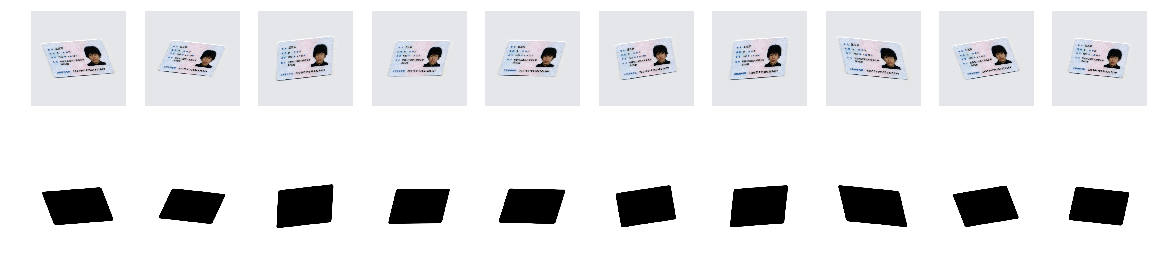

In [0]:
fig, axes = plt.subplots(2, 10, figsize=(20, 5)) # смотрим на первые 10 с масками
for k in range(10):
    axes[0,k].set_axis_off()
    axes[0,k].imshow(train_x[k])
    axes[1,k].set_axis_off()
    axes[1,k].imshow(train_y[k].squeeze())


In [0]:
input_layer = Input((h_size, w_size, 3))

In [0]:
input_layer.shape

TensorShape([Dimension(None), Dimension(512), Dimension(512), Dimension(3)])

In [0]:
output_layer = build_model(input_layer, 16)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-3), metrics=[my_iou_metric])

In [0]:
model.save_weights('./keras.weights')

In [0]:







while True:
    history = model.fit(train_x, train_y,
                        batch_size=32,
                        epochs=1,
                        verbose=1,
                        validation_split=0.1
                       )
    if history.history['my_iou_metric'][0] > 0.75:
        break


Train on 90 samples, validate on 10 samples
Epoch 1/1


ResourceExhaustedError: ignored

In [0]:
def next_pair():
    
    p = np.random.sample() - 0.5 # это выбор цвета фон/эллипс
    r = np.random.sample()*(w_size-2*radius_max) + radius_max
    c = np.random.sample()*(w_size-2*radius_max) + radius_max
    r_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    c_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    rot = np.random.sample()*360
    rr, cc = ellipse(r, c, r_radius, c_radius, rotation=np.deg2rad(rot), shape=img_l.shape)

    if p > 0: #  если выбрали фон потемнее
        img = img_l.copy()
        img[rr, cc] = img_h[rr, cc]
    else: #  если выбрали фон светлее
        img = img_h.copy()
        img[rr, cc] = img_l[rr, cc]
        
    msk = np.zeros((w_size, w_size, 1), dtype='float32')
    msk[rr, cc] = 1.

    return img, msk


In [0]:
for k in range(train_num):
    img, msk = next_pair()
    
    train_x[k] = img
    train_y[k] = msk

fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for k in range(10):
    axes[0,k].set_axis_off()
    axes[0,k].imshow(train_x[k])
    axes[1,k].set_axis_off()
    axes[1,k].imshow(train_y[k].squeeze())

In [0]:
input_layer = Input((w_size, w_size, 3))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-3), metrics=[my_iou_metric])
model.load_weights('./keras.weights', by_name=False)

# model.summary()

# while True:
#     history = model.fit(train_x, train_y,
#                         batch_size=32,
#                         epochs=1,
#                         verbose=1,
#                         validation_split=0.1
#                        )
#     if history.history['my_iou_metric'][0] > 0.75:
#         break


In [0]:
def next_pair():
    #  выбираем также как и ранее параметры эллипса
    p = np.random.sample() - 0.5
    r = np.random.sample()*(w_size-2*radius_max) + radius_max
    c = np.random.sample()*(w_size-2*radius_max) + radius_max
    r_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    c_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    rot = np.random.sample()*360
    rr, cc = ellipse(r, c, r_radius, c_radius, rotation=np.deg2rad(rot), shape=img_l.shape)

    p1 = np.rint(np.random.sample()*(w_size-2*radius_max) + radius_max)
    p2 = np.rint(np.random.sample()*(w_size-2*radius_max) + radius_max)
    p3 = np.rint(np.random.sample()*(2*radius_max - radius_min) + radius_min)
    p4 = np.rint(np.random.sample()*(2*radius_max - radius_min) + radius_min)

  #  выбираем параметры прямоугольника/помехи, задаем четыре угла
    poly = np.array((
        (p1, p2),
        (p1, p2+p4),
        (p1+p3, p2+p4),
        (p1+p3, p2),
        (p1, p2),
    ))
    rr_p, cc_p = polygon(poly[:, 0], poly[:, 1], img_l.shape)

    in_sc = list(set(rr) & set(rr_p)) #  следим за тем, что бы прямоугольник
                                      #  не пересекался с эллипсом
                                      #  и сдвигаем его в сторону при необходимости
    if len(in_sc) > 0:
        if np.mean(rr_p) > np.mean(in_sc):
            poly += np.max(in_sc) - np.min(in_sc)
        else:
            poly -= np.max(in_sc) - np.min(in_sc)
    rr_p, cc_p = polygon(poly[:, 0], poly[:, 1], img_l.shape)
    
    if p > 0:
        img = img_l.copy()
        img[rr, cc] = img_h[rr, cc]
        img[rr_p, cc_p] = img_h[rr_p, cc_p]
    else:
        img = img_h.copy()
        img[rr, cc] = img_l[rr, cc]
        img[rr_p, cc_p] = img_l[rr_p, cc_p]
        
    msk = np.zeros((w_size, w_size, 1), dtype='float32')
    msk[rr, cc] = 1.

    return img, msk


In [0]:
for k in range(train_num):
    img, msk = next_pair()
    
    train_x[k] = img
    train_y[k] = msk

fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for k in range(10):
    axes[0,k].set_axis_off()
    axes[0,k].imshow(train_x[k])
    axes[1,k].set_axis_off()
    axes[1,k].imshow(train_y[k].squeeze())


In [0]:
input_layer = Input((w_size, w_size, 3))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-3), metrics=[my_iou_metric])
model.load_weights('./keras.weights', by_name=False)

# model.summary()

# while True:
#     history = model.fit(train_x, train_y,
#                         batch_size=32,
#                         epochs=1,
#                         verbose=1,
#                         validation_split=0.1
#                        )
#     if history.history['my_iou_metric'][0] > 0.75:
#         break


In [0]:
def next_pair():
    
    p = np.random.sample() - 0.5
    r = np.random.sample()*(w_size-2*radius_max) + radius_max
    c = np.random.sample()*(w_size-2*radius_max) + radius_max
    r_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    c_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    rot = np.random.sample()*360
    rr, cc = ellipse(r, c, r_radius, c_radius, rotation=np.deg2rad(rot), shape=img_l.shape)

    p0 = np.rint(np.random.sample()*(radius_max-radius_min) + radius_min)
    p1 = np.rint(np.random.sample()*(w_size-radius_max))
    p2 = np.rint(np.random.sample()*(w_size-radius_max))
    p3 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p4 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p5 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p6 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p7 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p8 = np.rint(np.random.sample()*2.*radius_min - radius_min)


    poly = np.array((
        (p1, p2),
        (p1+p3, p2+p4+p0),
        (p1+p5+p0, p2+p6+p0),
        (p1+p7+p0, p2+p8),
        (p1, p2),
    ))
    rr_p, cc_p = polygon(poly[:, 0], poly[:, 1], img_l.shape)

    in_sc = list(set(rr) & set(rr_p))
    if len(in_sc) > 0:
        if np.mean(rr_p) > np.mean(in_sc):
            poly += np.max(in_sc) - np.min(in_sc)
        else:
            poly -= np.max(in_sc) - np.min(in_sc)
    rr_p, cc_p = polygon(poly[:, 0], poly[:, 1], img_l.shape)
    
    if p > 0:
        img = img_l.copy()
        img[rr, cc] = img_h[rr, cc]
        img[rr_p, cc_p] = img_h[rr_p, cc_p]
    else:
        img = img_h.copy()
        img[rr, cc] = img_l[rr, cc]
        img[rr_p, cc_p] = img_l[rr_p, cc_p]
        
    msk = np.zeros((w_size, w_size, 1), dtype='float32')
    msk[rr, cc] = 1.

    return img, msk


In [0]:
for k in range(train_num):
    img, msk = next_pair()
    
    train_x[k] = img
    train_y[k] = msk

fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for k in range(10):
    axes[0,k].set_axis_off()
    axes[0,k].imshow(train_x[k])
    axes[1,k].set_axis_off()
    axes[1,k].imshow(train_y[k].squeeze())


In [0]:
input_layer = Input((w_size, w_size, 3))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-3), metrics=[my_iou_metric])
model.load_weights('./keras.weights', by_name=False)

# model.summary()

# while True:
#     history = model.fit(train_x, train_y,
#                         batch_size=32,
#                         epochs=1,
#                         verbose=1,
#                         validation_split=0.1
#                        )
#     if history.history['my_iou_metric'][0] > 0.75:
#         break


In [0]:
def next_pair(_n = 7):
    
    p = np.random.sample() - 0.5
    c_x = np.random.sample()*(w_size-2*radius_max) + radius_max
    c_y = np.random.sample()*(w_size-2*radius_max) + radius_max
    radius = np.random.sample()*(radius_max-radius_min) + radius_min
    d = np.random.sample()*0.5 + 1
    a_deg = np.random.sample()*360
    a_rad = np.deg2rad(a_deg)
    
    poly = [] #  строим точки семиугольника
    for k in range(_n):
        poly.append(c_x+radius*math.sin(2.*k*math.pi/_n)) #  сначала точки правильного семиугольника
        poly.append(c_y+radius*math.cos(2.*k*math.pi/_n)) #  с_х с_у -координаты центра
        poly[-2] = (poly[-2]-c_x)/d +c_x #  сжимаем\проецируем семиугольник
        poly[-1] = (poly[-1]-c_y) +c_y   #  на произвольную от 0.5 до 1.5 величину
        #  поворачиваем на случайный угол
        poly[-2] = ((poly[-2]-c_x)*math.cos(a_rad) - (poly[-1]-c_y)*math.sin(a_rad)) + c_x
        poly[-1] = ((poly[-2]-c_x)*math.sin(a_rad) + (poly[-1]-c_y)*math.cos(a_rad)) + c_y

    poly = np.rint(poly).reshape(-1,2)
    rr, cc = polygon(poly[:, 0], poly[:, 1], img_l.shape)
    #    rr, cc = ellipse(r, c, r_radius, c_radius, rotation=np.deg2rad(rot), shape=img_l.shape)

    p0 = np.rint(np.random.sample()*(radius_max-radius_min) + radius_min)
    p1 = np.rint(np.random.sample()*(w_size-radius_max))
    p2 = np.rint(np.random.sample()*(w_size-radius_max))
    p3 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p4 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p5 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p6 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p7 = np.rint(np.random.sample()*2.*radius_min - radius_min)
    p8 = np.rint(np.random.sample()*2.*radius_min - radius_min)


    poly = np.array((
        (p1, p2),
        (p1+p3, p2+p4+p0),
        (p1+p5+p0, p2+p6+p0),
        (p1+p7+p0, p2+p8),
        (p1, p2),
    ))
    rr_p, cc_p = polygon(poly[:, 0], poly[:, 1], img_l.shape)

    in_sc = list(set(rr) & set(rr_p))
    if len(in_sc) > 0:
        if np.mean(rr_p) > np.mean(in_sc):
            poly += np.max(in_sc) - np.min(in_sc)
        else:
            poly -= np.max(in_sc) - np.min(in_sc)
    rr_p, cc_p = polygon(poly[:, 0], poly[:, 1], img_l.shape)
    
    if p > 0:
        img = img_l.copy()
        img[rr, cc] = img_h[rr, cc]
        img[rr_p, cc_p] = img_h[rr_p, cc_p]
    else:
        img = img_h.copy()
        img[rr, cc] = img_l[rr, cc]
        img[rr_p, cc_p] = img_l[rr_p, cc_p]
        
    msk = np.zeros((w_size, w_size, 1), dtype='float32')
    msk[rr, cc] = 1.

    return img, msk


In [0]:
for k in range(train_num):
    img, msk = next_pair()
    
    train_x[k] = img
    train_y[k] = msk

fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for k in range(10):
    axes[0,k].set_axis_off()
    axes[0,k].imshow(train_x[k])
    axes[1,k].set_axis_off()
    axes[1,k].imshow(train_y[k].squeeze())


In [0]:
input_layer = Input((w_size, w_size, 3))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss=dice_loss, optimizer=Adam(lr=1e-3), metrics=[my_iou_metric])
model.load_weights('./keras.weights', by_name=False)

# model.summary()

# while True:
#     history = model.fit(train_x, train_y,
#                         batch_size=32,
#                         epochs=1,
#                         verbose=1,
#                         validation_split=0.1
#                        )
#     if history.history['my_iou_metric'][0] > 0.75:
#         break
